In [360]:
import os
import re
import json
import glob
import string
import operator
import datetime
from collections import Counter
import itertools
import pandas as pd
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import IPython.display
from IPython.display import display
# plt.rc('font', serif='Times New Roman', family='serif', size=12.0)

# Word processing

In [113]:
pg_stopwords_filepath = '/usr/local/Cellar/postgresql/9.6.1/share/postgresql/tsearch_data/english.stop'
pg_stopwords = set(line.strip() for line in open(pg_stopwords_filepath))
print '|pg_stopwords| =', len(pg_stopwords)

|pg_stopwords| = 127


In [112]:
nltk_stopwords_filepath = os.path.expanduser('~/nltk_data/corpora/stopwords/english')
nltk_stopwords = set(line.strip() for line in open(nltk_stopwords_filepath))
print '|nltk_stopwords| =', len(nltk_stopwords)

|nltk_stopwords| = 153


In [109]:
google_1t_stopwords = set(line.strip() for line in open('google-1t.txt'))
print '|google_1t_stopwords| =', len(google_1t_stopwords)

|google_1t_stopwords| = 193


In [110]:
alphabet = set(string.ascii_lowercase)
print '|alphabet| =', len(alphabet)

|alphabet| = 26


In [493]:
contraction_suffixes = set(['s', 'm', 're', 've', 'll', 'd', 't'])
contraction_prefixes = set(['don', 'isn'])

In [494]:
standard_stopwords = google_1t_stopwords | contraction_suffixes | contraction_prefixes

In [495]:
def tokenize(s, stopwords=None):
    # normalize abbreviations to avoid stranded initials
    s = re.sub(r'(?:[A-Z]\.)+', lambda m: m.group(0).replace('.', ''), s)
    # normalize numbers to avoid 000 turning up as a significant token
    s = re.sub(r',(\d{3})\b', r'\1', s)
    # replace all non-alphanumerics with spaces
    s = re.sub(r'[^\w]', ' ', s)
    for token in s.lower().strip().split():
        if stopwords is None or token not in stopwords:
            yield token

In [200]:
def speeches_to_counts(speeches, stopwords=None):
    tokens = [token for speech in speeches for token in tokenize(speech['text'], stopwords)]
    return Counter(tokens)

In [201]:
def normalize_counts(counts, smoothing=0.0):
    total = float(sum(counts.values()))
    return {k: (v + smoothing) / total for k, v in counts.items()}

In [585]:
def read_lines(filepaths):
    for filepath in filepaths:
        with open(filepath) as fp:
            for line in fp:
                yield line

In [592]:
def google_1t_frequencies(tokens):
    '''
    Assuming tokens are lower-case.
    '''
    remaining_tokens = set(tokens)
    google_1t_filepath_lower = os.path.expanduser(
        '~/corpora-public/Google-1T-unigrams-only/derivatives/vocab_cs_lower')
    with open(google_1t_filepath_lower) as fp:
        for line in fp:
            token, count_string = line.decode('utf-8').split('\t')
            if token in remaining_tokens:
                remaining_tokens.remove(token)
                yield token, float(count_string) / 1024908267229.0
            if len(remaining_tokens) == 0:
                # exit as soon as we're done
                break

## Speech loading

In [302]:
def read_inaugural():
    for line in read_lines(['../data/tapp/inaugurals.json']):
        yield json.loads(line)

In [140]:
pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                               if 'Trump' not in speech['author'])
print '# tokens:', sum(pretrump_inaugural_counts.values())

# tokens: 134797


In [141]:
# prewar_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
#                                              if speech['timestamp'] < '1948-11-01')
# print '# tokens:', sum(prewar_inaugural_counts.values())

In [142]:
postwar_pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                                       if speech['timestamp'] > '1948-11-01' 
                                                       and 'Trump' not in speech['author'])
print '# tokens:', sum(postwar_pretrump_inaugural_counts.values())
# print 'top 50 types:', postwar_pretrump_inaugural_counts.most_common(50)

# tokens: 33938


In [143]:
def read_election2016_speeches():
    for line in read_lines(['../data/tapp/election2016.json']):
        speech = json.loads(line)
        title = speech['title']
        if 'Press Release' not in title and 'Statement by' not in title:
            yield speech

In [145]:
trump_election2016_counts = speeches_to_counts(speech for speech in read_election2016_speeches()
                                               if speech['author'] == 'Donald J. Trump')
print '# tokens:', sum(trump_election2016_counts.values())
# print 'top 50 types:', trump_election2016_counts.most_common(50)

# tokens: 163681


# Proportion of speech allocated to specific word groups

In [288]:
synsets = [
    ('freedom(s)', ['freedom', 'freedoms']),
    ('justice', ['justice']),
    ('liberty(ies)', ['liberty', 'liberties']),
    ('freedom(s)+\nliberty(ies)', ['freedom', 'freedoms', 'liberty', 'liberties']),
    ('rights', ['rights']),
    ('america(n(s))', ['america', 'american', 'americans']),
    ('job(s)', ['job', 'jobs']),
]

In [289]:
def proportional_usage(tokens, counts):
    maximum = sum(counts.values())
    usage = sum(counts.get(token, 0) for token in tokens)
    return float(usage) / float(maximum)

def synset_proportional_usages(synsets, counts):
    return {synset_name: proportional_usage(synset_tokens, counts) for synset_name, synset_tokens in synsets}

In [290]:
def iter_usages():
    sources = [('All pre-Trump inaugural speeches', pretrump_inaugural_counts),
               #('Pre-war inaugural speeches', prewar_inaugural_counts),
               ('Post-war, pre-Trump inaugural speeches', postwar_pretrump_inaugural_counts),
               ('Trump campaign speeches', trump_election2016_counts)]
    for source_name, source_counts in sources:
        for synset_name, synset_tokens in synsets:
            usage = proportional_usage(synset_tokens, source_counts)
            yield dict(source=source_name, synset=synset_name, usage=usage)

In [291]:
df_usages = pd.DataFrame.from_dict(iter_usages())

In [292]:
df_usages_t = df_usages.pivot(index='synset', columns='source', values='usage')
df_usages_t

source,All pre-Trump inaugural speeches,"Post-war, pre-Trump inaugural speeches",Trump campaign speeches
synset,,,
america(n(s)),0.007269,0.007838,0.022506
freedom(s),0.003275,0.003683,0.000284
freedom(s)+\nliberty(ies),0.005589,0.005039,0.000460
job(s),0.000223,0.000354,0.010007
justice,0.002349,0.001149,0.000894
liberty(ies),0.002314,0.001355,0.000176
rights,0.002366,0.000648,0.000325


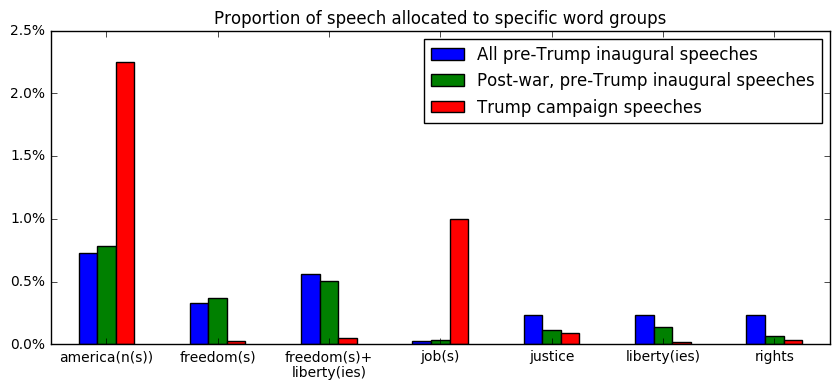

In [293]:
ax = df_usages_t.plot(figsize=(8.5, 4), kind='bar')
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.01%}'.format(y))) 
legend = ax.legend()
legend.set_title(None)
plt.xticks(rotation=0)
plt.title('Proportion of speech allocated to specific word groups')
plt.tight_layout()
# plt.savefig('grouped_proportions.nostopwords.pdf')

# Inaugural address word count

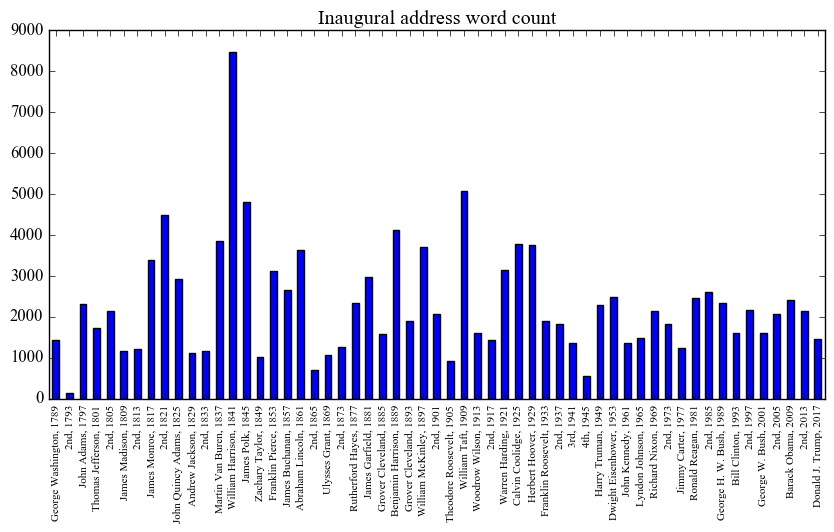

In [680]:
ordinal_mapping = {'First': '1st', 'Second': '2nd', 'Third': '3rd', 'Fourth': '4th'}
def get_inaugural_ticklabels(df):
    last_author = None
    for _, speech in df.iterrows():
        author = speech.author
        title = ordinal_mapping[speech.title.split()[0]] if author == last_author else author
        last_author = author
        yield title + ', ' + str(speech.timestamp.year)
# draw plot for all inaugurals
ax = df.plot(x='timestamp', y='word_count', figsize=(8.5, 5.5), kind='bar', legend=False, 
             title="Inaugural address word count")
ticklabels = list(get_inaugural_ticklabels(df))
for label in ax.get_xticklabels():
    label.set_fontsize(8)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig('inaugural_word_count.pdf')

# Surname mentions in inaugural speeches

In [322]:
pd.options.display.max_rows = 5
pd.options.display.max_columns = 5

In [323]:
def iter_surnames():
    speeches = list(read_inaugural())
    surnames = set([speech['author'].split()[-1] for speech in speeches])
    for speech in speeches:
        text = speech['text']
        for surname in surnames:
            title = speech['author'] + ': ' + speech['title']
            surname_count = text.count(surname)
            yield dict(title=title, surname=surname, count=surname_count)

In [324]:
df_surnames = pd.DataFrame.from_dict(iter_surnames())
df_surnames

,count,surname,title
0,0,Wilson,George Washington: Inaugural Address
1,0,Jackson,George Washington: Inaugural Address
...,...,...,...
2028,0,Polk,Donald J. Trump: Inaugural Address
2029,0,Monroe,Donald J. Trump: Inaugural Address


In [325]:
df_xtab = df_surnames.pivot(index='title', columns='surname', values='count')
df_xtab

surname,Adams,Buchanan,...,Washington,Wilson
title,,,,,
Abraham Lincoln: Inaugural Address,0,0,...,0,0
Abraham Lincoln: Second Inaugural Address,0,0,...,0,0
...,...,...,...,...,...
Woodrow Wilson: Second Inaugural Address,0,0,...,0,0
Zachary Taylor: Inaugural Address,0,0,...,1,0


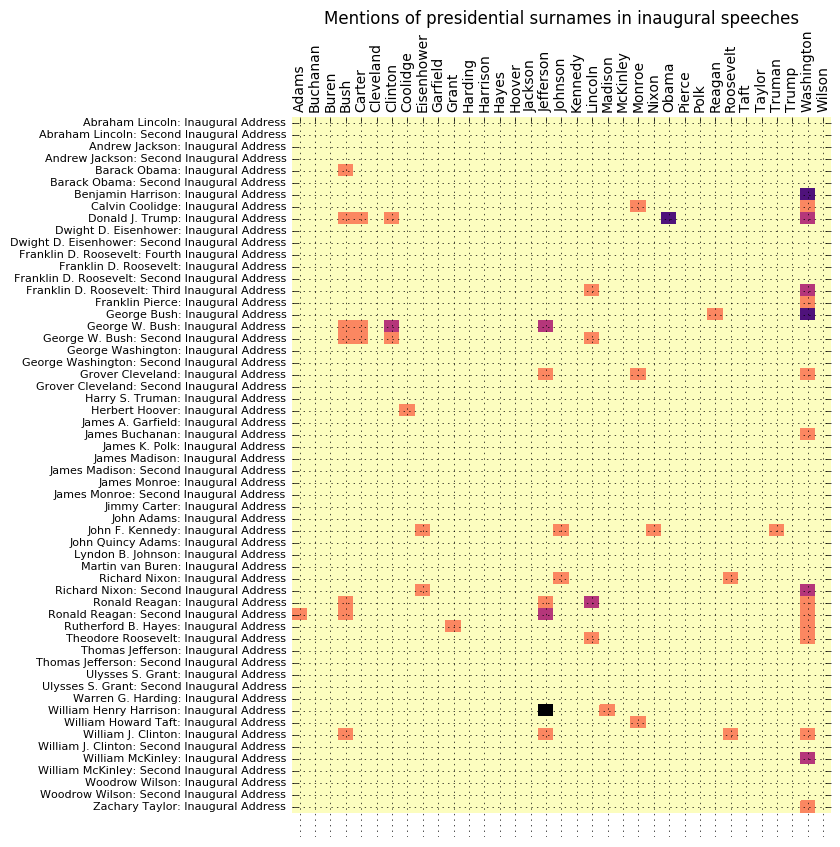

In [326]:
# based on https://stackoverflow.com/a/16124677
plt.figure(figsize=(8.5, 8.5))
plt.pcolor(df_xtab, cmap=plt.cm.magma_r)
ax = plt.axes()
ax.set_frame_on(False)
ax.set_yticks(np.arange(df_xtab.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(df_xtab.shape[1]) + 0.5, minor=False)
# flip x-ticks/labels to top
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
# ax.xaxis.tick_top()
plt.xticks(rotation=90)
# set the x/y tick labels
ax.set_xticklabels(df_xtab.columns, minor=False)
ax.set_yticklabels(df_xtab.index, minor=False)
ax.grid(True)
# better label fit
for label in ax.get_yticklabels():
    label.set_fontsize(8)
plt.title('Mentions of presidential surnames in inaugural speeches', y=1.12)
plt.tight_layout()
# plt.savefig('inaugural_surnames.pdf')

# Self mentions in speeches


# Significant others

In [496]:
def iter_counts(groups, vocab, smoothing=0):
    '''
    groups: a list of (group_name, group_counts) pairs
    vocab: a set/list of tokens
    '''
    for group_name, group_counts in groups:
        for word in vocab:
            yield dict(group=group_name, word=word, word_count=group_counts.get(word, 0) + smoothing)

In [497]:
def set_proportion(df):
    '''
    This seems ugly as the argument to pd.GroupedDataSeries.apply(), but it works
    '''
    df['proportion'] = df['word_count'] / np.sum(df['word_count'])
    return df

In [635]:
pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

In [636]:
# postwar pre-trump
# inaugural_counts = speeches_to_counts(
#     (speech for speech in read_inaugural() 
#      if speech['timestamp'] > '1948-11-01' 
#      and 'Trump' not in speech['author']), standard_stopwords)
# all pre-trump
inaugural_counts = speeches_to_counts(
    (speech for speech in read_inaugural() 
     if 'Trump' not in speech['author']), standard_stopwords)
print '|inaugural_counts| =', sum(inaugural_counts.values())

|inaugural_counts| = 58308


In [637]:
trump_election2016_counts = speeches_to_counts(
    (speech for speech in read_election2016_speeches()
     if speech['author'] == 'Donald J. Trump'), standard_stopwords)
print '|tokens| =', sum(trump_election2016_counts.values())

|tokens| = 73319


In [638]:
groups = [('inaugural', inaugural_counts),
          ('trump', trump_election2016_counts)]

In [639]:
full_vocab = set([token for _, counts in groups for token in counts.keys()]) # 12219
print '|full_vocab| =', len(full_vocab)

|full_vocab| = 12273


In [643]:
df_counts = pd.DataFrame.from_dict(iter_counts(groups, full_vocab, 1.0)).groupby('group').apply(set_proportion)
# df_counts

In [642]:
# derive more condensed vocabulary
df_proportions_merged = df_counts.groupby('word').agg({'proportion': sum})
# df_proportions_merged.sort_values('proportion', ascending=False)

In [644]:
vocab = set(df_proportions_merged.nlargest(100, 'proportion').index)
print '|vocab| =', len(vocab)

|vocab| = 100


In [645]:
print ' '.join(vocab)

office money years bring children thank justice better policy hope good government nation know world trade like countries common security right people national year best said constitution federal god business state energy public jobs power men free job change great freedom citizens against foreign american military think first clinton campaign political down americans another vote millions america union illegal support question system long means war today interests life immigration hillary believe spirit obama look rights work nations future country history trump tax fellow states need united end peace administration congress african plan president law man applause well together time laws


In [646]:
# could take a second depending on how rare the vocab is
vocab_1t_frequencies = dict(google_1t_frequencies(vocab))

In [647]:
# recount with condensed vocab
df_counts = pd.DataFrame.from_dict(iter_counts(groups, vocab, 1.0)).groupby('group').apply(set_proportion)
# df_counts.sort_values('proportion', ascending=False)

### Oh boy word clouds

In [648]:
from wordcloud import WordCloud

In [649]:
def display_frequencies_wordcloud(frequencies):
    #wordCloud = WordCloud(max_font_size=40)
    wordCloud = WordCloud()
    wordCloud_generated = wordCloud.generate_from_frequencies(frequencies)
    plt.imshow(wordCloud_generated)
    plt.axis('off')

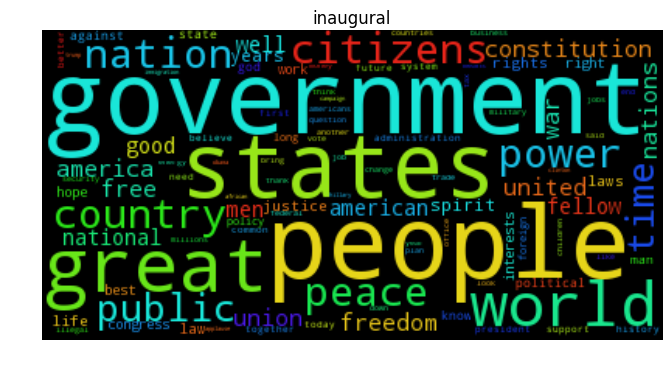

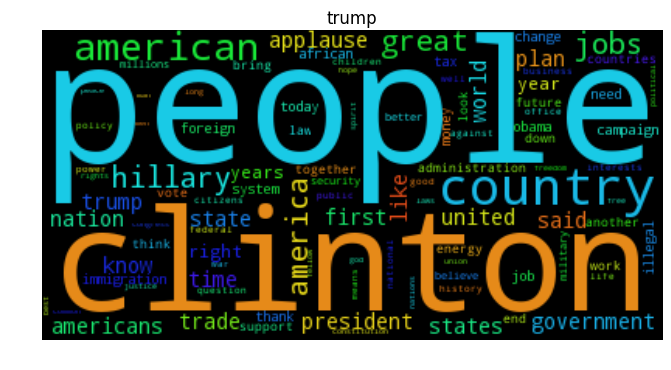

In [652]:
for group, group_df in df_counts.groupby('group'):
    plt.figure(figsize=(8.5, 4))
    display_frequencies_wordcloud(zip(group_df.word, group_df.proportion))    
    plt.title(group)

### Back to business

In [657]:
df_proportions = df_counts.pivot(index='word', columns='group', values='proportion')

In [658]:
df_proportions['trump/inaugural'] = df_proportions.trump / df_proportions.inaugural

In [659]:
df_proportions['google_1t'] = df_proportions.index.map(lambda k: vocab_1t_frequencies[k])

In [660]:
pd.options.display.max_rows = 50

In [661]:
df_proportions.sort_values('trump/inaugural')

group,inaugural,trump,trump/inaugural,google_1t
word,,,,
union,0.016426,0.000210,0.012757,7.084063e-05
fellow,0.013124,0.000629,0.047904,1.609653e-05
freedom,0.016600,0.001048,0.063119,3.796964e-05
nations,0.017122,0.001100,0.064256,3.068620e-05
spirit,0.012168,0.000838,0.068890,3.607843e-05
peace,0.022249,0.002253,0.101249,4.671332e-05
rights,0.012081,0.001310,0.108415,3.434989e-04
constitution,0.018251,0.001991,0.109076,1.994120e-05
free,0.016079,0.002567,0.159657,9.895182e-04


In [ ]:
x = df_proportions['google_1t']
y = df_proportions['trump/inaugural']
plt.figure(figsize=(8.5, 5.5))
plt.yscale('log')
plt.xscale('log')
plt.scatter(x, y)
for label, x, y in zip(df_proportions.index, x, y):
    plt.annotate(label, xy=(x, y), xytext=(2, 2),
        textcoords='offset points', ha='left', va='bottom')
plt.xlabel('global frequency of word (based on Google 1T unigrams)')
plt.ylabel(u'relative\n<- inauguralness or Trumpery ->')
plt.tight_layout()
plt.savefig('relative_trumpery_scatter_100.pdf')